Configurazione Iniziale Completata.
Funzioni definite
Funzioni di attacco definite.
Costruzione Modello LNN...


I0000 00:00:1764844282.345260    4792 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4130 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Modello Caricato e Pesi Ripristinati.
Caricamento 3000 batch di dati puliti...
Dati caricati: (768000, 30, 4)
Iniezione Attacchi...
Esecuzione Predizioni LNN...
3000/3000 [==============================] - 48s 16ms/step

Soglia Calcolata (Mean+3Std su Normali): 0.025307

🛡️ REPORT LNN-ONLY (N=768000)
              precision    recall  f1-score   support

      Normal       0.51      0.99      0.68    153600
      Attack       1.00      0.77      0.87    614400

    accuracy                           0.81    768000
   macro avg       0.75      0.88      0.77    768000
weighted avg       0.90      0.81      0.83    768000

--------------------------------------------------
SCENARIO             | RILEVATI            | RATE      
--------------------------------------------------
1. Speed Spoofing    | 153600   / 153600   | 100.00%
2. Teleport          | 153600   / 153600   | 100.00%
3. Ghost Ship        | 10599    / 153600   | 6.90%
4. Silent Drift      | 153600   / 153600   | 100.00%
---

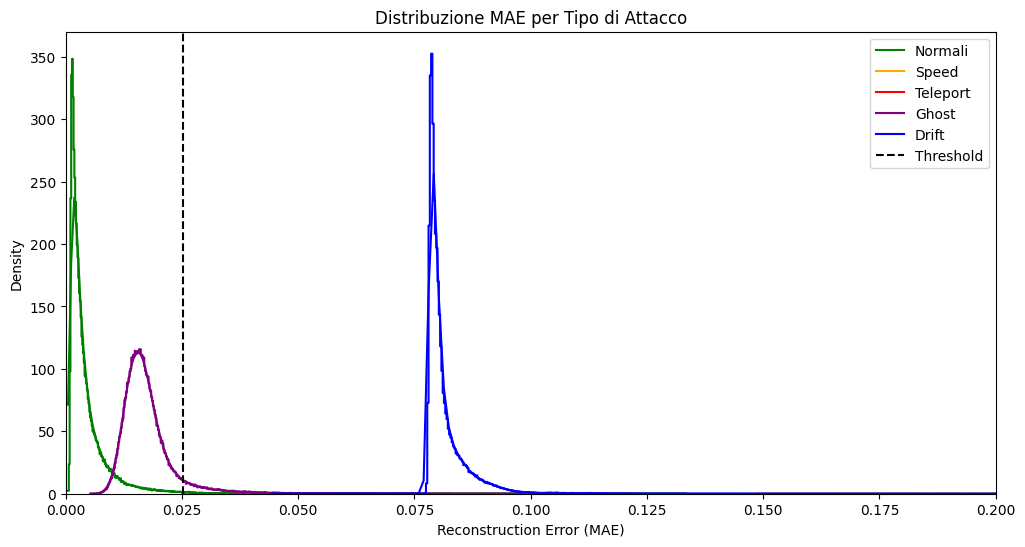

In [1]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import gc

# Import LNN
from ncps.tf import CfC
from ncps.wirings import AutoNCP
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, RepeatVector
from tensorflow.keras import mixed_precision

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Configurazione GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError: pass

# --- CONFIGURAZIONE ---
WINDOW_SIZE = 30
BATCH_SIZE = 256 # O quello che preferisci per il test
COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset_Ready_For_AI_FINAL' # Assicurati che il path sia corretto
SCALER_PATH = 'scaler.joblib'
WEIGHTS_PATH = 'lnn_autoencoder_best.weights.h5'

# Parametri Modello LNN (Devono corrispondere a quelli del training)
RECURRENT_UNITS = 128
BOTTLENECK_SIZE = 64

print("Configurazione Iniziale Completata.")

# --- FUNZIONI DI SUPPORTO ---

def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
             # Shuffle disattivato forzatamente per garantire la sequenzialità
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        # Se la traiettoria tocca la fine del chunk, bufferizzala
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue
print("Funzioni definite")
    
# Se non vuoi ricopiare tutta la funzione data_generator_v, assicurati di averla definita in una cella precedente o importala.
# Qui metto un placeholder, SOSTITUISCILO con la tua funzione reale.

# --- DEFINIZIONE ATTACCHI ---

def inject_attacks(X_clean):
    n_samples = len(X_clean)
    n_cats = 5 # 1 Normale + 4 Attacchi
    split_size = n_samples // n_cats
    
    X_mixed = X_clean.copy()
    y_true = np.zeros(n_samples)
    attack_type = np.zeros(n_samples) # 0:Normal, 1:Speed, 2:Teleport, 3:Ghost, 4:Drift

    # Indici
    idx_norm = range(0, split_size)
    idx_speed = range(split_size, 2*split_size)
    idx_tele = range(2*split_size, 3*split_size)
    idx_ghost = range(3*split_size, 4*split_size)
    idx_drift = range(4*split_size, n_samples) # Arriva fino alla fine

    # 1. Speed Spoofing (Rumore forte su SOG)
    # Aggiungiamo rumore significativo alla velocità
    noise_speed = np.random.normal(5.0, 2.0, X_mixed[idx_speed, :, 2].shape) 
    X_mixed[idx_speed, :, 2] += noise_speed
    y_true[idx_speed] = 1
    attack_type[idx_speed] = 1

    # 2. Teleport (Salto di posizione finale)
    # Salto improvviso negli ultimi 5 step
    X_mixed[idx_tele, -5:, 0] += 0.5 
    X_mixed[idx_tele, -5:, 1] += 0.5
    y_true[idx_tele] = 1
    attack_type[idx_tele] = 2

    # 3. Ghost Ship (Inversione Rotta + Jitter)
    # Inversione COG (180 gradi circa) + rumore
    X_mixed[idx_ghost, :, 3] = (X_mixed[idx_ghost, :, 3] + 0.5) % 1.0 
    X_mixed[idx_ghost, :, 3] += np.random.normal(0, 0.1, X_mixed[idx_ghost, :, 3].shape)
    y_true[idx_ghost] = 1
    attack_type[idx_ghost] = 3

    # 4. Silent Drift (Deriva progressiva)
    # Drift lineare da 0 a 0.01 (più sottile per testare la sensibilità)
    drift_rate = 0.01
    steps = np.arange(WINDOW_SIZE)
    drift_vector = steps * drift_rate
    # Applicazione vettoriale con broadcasting
    # X_mixed[idx_drift, :, 0] shape è (N, 30) -> drift_vector shape (30,) broadcasta correttamente
    X_mixed[idx_drift, :, 0] += drift_vector 
    X_mixed[idx_drift, :, 1] += drift_vector
    y_true[idx_drift] = 1
    attack_type[idx_drift] = 4
    
    return X_mixed, y_true, attack_type, idx_norm, idx_speed, idx_tele, idx_ghost, idx_drift

print("Funzioni di attacco definite.")

# --- CARICAMENTO MODELLO ---

if not os.path.exists(SCALER_PATH) or not os.path.exists(WEIGHTS_PATH):
    print("ERRORE: Scaler o Pesi non trovati.")
else:
    scaler = joblib.load(SCALER_PATH)
    all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
    TEST_FILES = all_files[20:24] # Usa i file di test che preferisci

    print("Costruzione Modello LNN...")
    wiring = AutoNCP(RECURRENT_UNITS, output_size=BOTTLENECK_SIZE)
    inputs = Input(shape=(WINDOW_SIZE, 4))
    lnn_encoder = CfC(wiring, return_sequences=False, mixed_memory=True)(inputs)
    repeat_vector = RepeatVector(WINDOW_SIZE)(lnn_encoder)
    lnn_decoder = CfC(wiring, return_sequences=True, mixed_memory=True)(repeat_vector)
    output = TimeDistributed(Dense(4))(lnn_decoder)
    model = Model(inputs, output)

    model.load_weights(WEIGHTS_PATH)
    print("Modello Caricato e Pesi Ripristinati.")
    
    # Inizializza Generatore (Assicurati di aver incollato la funzione data_generator_v sopra)
    # test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE, shuffle_files=False)


# --- ESECUZIONE TEST ---

# 1. Accumulo Dati Puliti
NUM_BATCHES_TEST = 3000 # Circa 100k campioni totali
X_list = []

print(f"Caricamento {NUM_BATCHES_TEST} batch di dati puliti...")
# Necessario reinizializzare il generatore qui per essere sicuri
test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE, shuffle_files=False)

try:
    for _ in range(NUM_BATCHES_TEST):
        b, _ = next(test_gen)
        X_list.append(b)
    X_clean_total = np.concatenate(X_list, axis=0)
except StopIteration:
    print("Generatore terminato prima del previsto.")
    X_clean_total = np.concatenate(X_list, axis=0)

print(f"Dati caricati: {X_clean_total.shape}")

# 2. Iniezione Attacchi
print("Iniezione Attacchi...")
X_test, y_true, attack_types, idx_norm, idx_speed, idx_tele, idx_ghost, idx_drift = inject_attacks(X_clean_total)

# 3. Predizione LNN
print("Esecuzione Predizioni LNN...")
reconstructions = model.predict(X_test, verbose=1, batch_size=BATCH_SIZE)

# 4. Calcolo MAE (Mean Absolute Error)
# Errore medio su tutte le feature per ogni campione
mae_loss = np.mean(np.abs(X_test - reconstructions), axis=(1, 2))

# 5. Calibrazione Soglia (sui dati Normali del test stesso)
# In un sistema reale useresti il validation set, qui usiamo la parte 'Normal' del test per calibrare
mae_normal = mae_loss[idx_norm]
THRESHOLD = np.mean(mae_normal) + 3 * np.std(mae_normal)

print(f"\nSoglia Calcolata (Mean+3Std su Normali): {THRESHOLD:.6f}")

# 6. Classificazione
y_pred = (mae_loss > THRESHOLD).astype(int)

# --- REPORT RISULTATI ---

print("\n" + "="*60)
print(f"🛡️ REPORT LNN-ONLY (N={len(y_pred)})")
print("="*60)

# Metriche Globali
print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))

# Dettaglio per Tipo
def print_result(name, idxs):
    total = len(idxs)
    caught = np.sum(y_pred[idxs])
    rate = (caught / total) * 100
    print(f"{name:<20} | {caught:<8} / {total:<8} | {rate:.2f}%")

print("-" * 50)
print(f"{'SCENARIO':<20} | {'RILEVATI':<19} | {'RATE':<10}")
print("-" * 50)
print_result("1. Speed Spoofing", idx_speed)
print_result("2. Teleport", idx_tele)
print_result("3. Ghost Ship", idx_ghost)
print_result("4. Silent Drift", idx_drift)
print("-" * 50)
print_result("*. Normali (FP)", idx_norm)
print("-" * 50)

# Visualizzazione Distribuzione Errori
plt.figure(figsize=(12, 6))
sns.histplot(mae_normal, color='green', label='Normali', kde=True, stat="density", element="step", fill=False)
sns.histplot(mae_loss[idx_speed], color='orange', label='Speed', kde=True, stat="density", element="step", fill=False)
sns.histplot(mae_loss[idx_tele], color='red', label='Teleport', kde=True, stat="density", element="step", fill=False)
sns.histplot(mae_loss[idx_ghost], color='purple', label='Ghost', kde=True, stat="density", element="step", fill=False)
sns.histplot(mae_loss[idx_drift], color='blue', label='Drift', kde=True, stat="density", element="step", fill=False)

plt.axvline(THRESHOLD, color='k', linestyle='--', label='Threshold')
plt.title("Distribuzione MAE per Tipo di Attacco")
plt.xlabel("Reconstruction Error (MAE)")
plt.legend()
plt.xlim(0, 0.2) # Focus sulla zona critica
plt.show()

🔬 AVVIO STRESS TEST PARAMETRICO (Soglia: 0.025307)...
   • Base dati: 256 campioni puliti.

1. Esecuzione Test Teleport (Salto Posizionale)...
   -> Salto 0.0010: Rilevato 0.0%
   -> Salto 0.0050: Rilevato 0.0%
   -> Salto 0.0100: Rilevato 0.0%
   -> Salto 0.0200: Rilevato 0.0%
   -> Salto 0.0500: Rilevato 0.0%
   -> Salto 0.0600: Rilevato 0.4%
   -> Salto 0.0700: Rilevato 100.0%
   -> Salto 0.0800: Rilevato 100.0%
   -> Salto 0.0900: Rilevato 100.0%
   -> Salto 0.1000: Rilevato 100.0%
   -> Salto 0.2000: Rilevato 100.0%
   -> Salto 0.5000: Rilevato 100.0%

2. Esecuzione Test Speed Spoofing (Intensità Rumore)...
   -> Rumore 0.1: Rilevato 0.4%
   -> Rumore 0.2: Rilevato 93.0%
   -> Rumore 0.3: Rilevato 100.0%
   -> Rumore 0.4: Rilevato 100.0%
   -> Rumore 0.5: Rilevato 100.0%
   -> Rumore 1.0: Rilevato 100.0%
   -> Rumore 2.0: Rilevato 100.0%
   -> Rumore 5.0: Rilevato 100.0%
   -> Rumore 10.0: Rilevato 100.0%

3. Esecuzione Test Silent Drift (Rateo Deriva)...
   -> Rateo 0.0001: Rilev

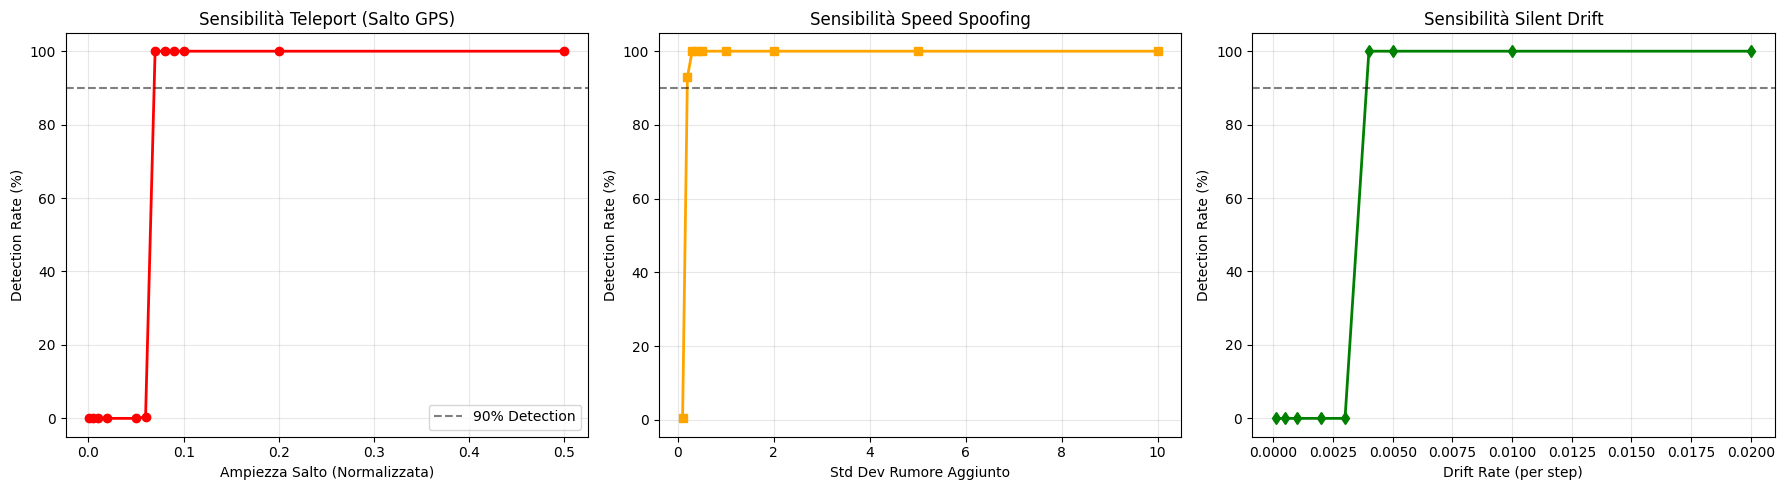

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURAZIONE SOGLIA (Usa quella calibrata a 128k campioni) ---
# Inserisci qui il valore esatto che hai ottenuto nell'ultimo test (es. 0.011255)
FINAL_THRESHOLD = 0.025307 

print(f"🔬 AVVIO STRESS TEST PARAMETRICO (Soglia: {FINAL_THRESHOLD})...")

# Funzione Helper per calcolare il Detection Rate su un batch
def get_detection_rate(X_attacked, model, threshold):
    preds = model.predict(X_attacked, verbose=0, batch_size=512)
    mae = np.mean(np.abs(X_attacked - preds), axis=(1, 2))
    # Quanti superano la soglia?
    rate = np.sum(mae > threshold) / len(mae)
    return rate * 100.0

# Carichiamo un batch di dati puliti da usare come base
# (Assumiamo che test_gen sia già definito e pronto)
try:
    X_base, _ = next(test_gen)
    # Ne prendiamo 5000 per velocità statistica
    X_base = X_base[:5000]
except:
    # Ricrea generatore se serve
    test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE)
    X_base, _ = next(test_gen)
    X_base = X_base[:5000]

print(f"   • Base dati: {len(X_base)} campioni puliti.")


# --- TEST 1: TELEPORT SENSITIVITY (Minimum Jump Distance) ---
print("\n1. Esecuzione Test Teleport (Salto Posizionale)...")

# Definiamo i salti da testare (in gradi normalizzati)
# Nota: Devi sapere a quanti metri corrisponde 0.001 nel tuo scaler.
# Approssimazione: se i dati sono scalati Standard o MinMax, 0.001 è piccolo, 0.1 è grande.
jump_values = [0.001, 0.005, 0.01, 0.02, 0.05,0.06,0.07,0.08,0.09,0.1, 0.2, 0.5]
teleport_rates = []

for j in jump_values:
    X_temp = X_base.copy()
    # Applica salto agli ultimi 5 step
    X_temp[:, -5:, 0] += j # Lat
    X_temp[:, -5:, 1] += j # Lon
    
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    teleport_rates.append(rate)
    print(f"   -> Salto {j:.4f}: Rilevato {rate:.1f}%")


# --- TEST 2: SPEED SPOOFING SENSITIVITY (Noise Intensity) ---
print("\n2. Esecuzione Test Speed Spoofing (Intensità Rumore)...")

noise_std_values = [0.1,0.2,0.3,0.4,0.5, 1.0, 2.0, 5.0, 10.0] # Deviazione standard del rumore aggiunto
speed_rates = []

for n in noise_std_values:
    X_temp = X_base.copy()
    noise = np.random.normal(0, n, X_temp[:, :, 2].shape)
    X_temp[:, :, 2] += noise
    
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    speed_rates.append(rate)
    print(f"   -> Rumore {n:.1f}: Rilevato {rate:.1f}%")


# --- TEST 3: SILENT DRIFT SENSITIVITY (Drift Rate) ---
print("\n3. Esecuzione Test Silent Drift (Rateo Deriva)...")

drift_values = [0.0001, 0.0005, 0.001, 0.002,0.003,0.004, 0.005, 0.01, 0.02]
drift_rates = []

steps = np.arange(WINDOW_SIZE)

for d in drift_values:
    X_temp = X_base.copy()
    drift_vec = steps * d
    # Applica deriva
    X_temp[:, :, 0] += drift_vec
    X_temp[:, :, 1] += drift_vec
    
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    drift_rates.append(rate)
    print(f"   -> Rateo {d:.4f}: Rilevato {rate:.1f}%")


# --- VISUALIZZAZIONE RISULTATI ---
plt.figure(figsize=(18, 5))

# Plot Teleport
plt.subplot(1, 3, 1)
plt.plot(jump_values, teleport_rates, 'o-', color='red', linewidth=2)
plt.title("Sensibilità Teleport (Salto GPS)")
plt.xlabel("Ampiezza Salto (Normalizzata)")
plt.ylabel("Detection Rate (%)")
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5, label='90% Detection')
plt.legend()

# Plot Speed
plt.subplot(1, 3, 2)
plt.plot(noise_std_values, speed_rates, 's-', color='orange', linewidth=2)
plt.title("Sensibilità Speed Spoofing")
plt.xlabel("Std Dev Rumore Aggiunto")
plt.ylabel("Detection Rate (%)")
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5)

# Plot Drift
plt.subplot(1, 3, 3)
plt.plot(drift_values, drift_rates, 'd-', color='green', linewidth=2)
plt.title("Sensibilità Silent Drift")
plt.xlabel("Drift Rate (per step)")
plt.ylabel("Detection Rate (%)")
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()